# Part2: Debiasing Facial Detection Systems

这部分将会探索两个深度学习应用的方面：面部识别和算法偏差.

对于长期使用AI系统，实现一个合理的、无偏差的系统变得十分重要. 考虑一个面部检测的任务：给出一张图片，判断它是否是一张人脸？这个问题看似简单，但却非常重要，在人口统计数据中存在大量算法偏差（algorithmic bias）的影响，无法达到完全准确.

在这里我们将使用这篇论文（[Uncovering and Mitigating Algorithmic Bias through Learned
Latent Structure](http://introtodeeplearning.com/AAAI_MitigatingAlgorithmicBias.pdf)）解决算法偏差的方法. 我们将建立一个通过学习人脸数据集的隐变量（latent variables）的面部识别模型，并且使用它来自适应重新采样训练数据，从而减轻任何可能存在的偏差（bias），以便去训练模型.

通过观看这个 [Google制作的视频](https://www.aliyundrive.com/s/A4LAf2hHWra) 了解机器学习中考虑偏差的重要性.

In [1]:
import tensorflow as tf  # 2.x
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import IPython
import functools
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import mitdeeplearning as mdl  # 0.2.0

## 2.1 Datasets

在这个试验中我们将使用三个数据集. 为了训练面部识别模型，我们将需要一个正样本(positive examples)数据集（例如：人脸图片）和一个负样本(negative examples)（例如：不是人脸的图片）. 我们将使用这些数据去训练我们的模型，去分辨图片是不是人脸. 最终我们需要一个全部为人脸图片的验证集. 由于考虑到我们的学习模型在特定人口统计数据中可能存在潜在偏见，于是测试集中的数据需要选取在人口统计中具有相同表示或关键特征部分近似的图片.

在本次试验中，我们将考虑肤色和性别.

1. 正训练集：名人训练集（[CelebA Dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)），超过二十万张名人照片.

2. 负训练集：[ImageNet](http://www.image-net.org/). 该网站上有非常多不同分类的图片，我们将从非人脸类别中选取负样本. 通过 [Fitzpatrick度量法](https://zhuanlan.zhihu.com/p/283280052) 对肤色进行分类，将图片标记为 "Lighter" 或 "Darker".

下面让我们从载入这些数据集开始，我们将编写一个类，用于对数据进行预处理，从而转化为可训练数据.

In [2]:
# Get the training data: both images from CelebA and ImageNet
path_to_training_data = tf.keras.utils.get_file('train_face.h5', 'https://www.dropbox.com/s/hlz8atheyozp1yx/train_face.h5?dl=1')
# Instantiate a TrainingDatasetLoader using the downloaded dataset
loader = mdl.lab2.TrainingDatasetLoader(path_to_training_data)

Opening C:\Users\HNTV\.keras\datasets\train_face.h5
Loading data into memory...


我们可以查看训练数据集的大小，并且每个batch大小划分为100.

In [3]:
number_of_training_examples = loader.get_train_size()
(images, labels) = loader.get_batch(100)  # 取出一个batch
print(f'照片总数：{number_of_training_examples}')
print(f'{images.shape=}, {labels.shape=}')

照片总数：109914
images.shape=(100, 64, 64, 3), labels.shape=(100, 1)


下面查看训练集中的正负样本. labels=1为正样本，0为负样本.

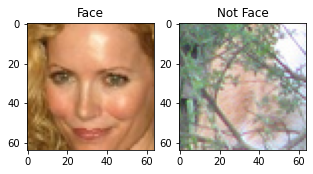

In [4]:
### Examining the CelebA training dataset ###
# Change the sliders to look at positive and negative training examples!

face_images = images[np.where(labels==1)[0]]
not_face_images = images[np.where(labels==0)[0]]

idx_face = 5  # 显示100中的第42个
idx_not_face = 30

plt.figure(figsize=(5,5))
plt.subplot(1, 2, 1)
plt.imshow(face_images[idx_face])
plt.title("Face"); plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(not_face_images[idx_not_face])
plt.title("Not Face"); plt.grid(False)

### 考虑偏差

如果分类决策在遇到一些潜在特征变化后，分类结果发生变化，则说明我们的分类器是存在偏差的. 处理偏差对于分类问题十分重要，因为对于大量的
人脸图片，要做到精确分类就需要消除这种偏差. 

## 2.2 CNN for facial detection

首先我们会定义并训练一个卷积神经网络(CNN)用于面部识别，并且评估其准确性. 其次，我们将评估我们模型是否具有偏差. 

CNN具有相对标准的架构，由一系列具有归一化的卷积层和两个全连接层构成.

该CNN模型没有再使用汇聚层(pooling)，是因为加入了卷积的步长，并且加入归一化操作，可以代替汇聚层的功能.

下面使用了： `functools.partial(func, *args)` 用于固定函数 `func` 中的参数，不必重复性输入函数的参数.

In [5]:
n_filters = 12 # 每个卷积层中卷积核的个数

def make_CNN_classifier(n_output=1):
    Conv2D = functools.partial(layers.Conv2D, padding='same', activation='relu')  # padding='same'表示进行零填充
    
    return keras.Sequential([
        Conv2D(filters=1*n_filters, kernel_size=5, strides=2, input_shape=(64, 64, 3)),  # strides为卷积的步长
        layers.BatchNormalization(),
        Conv2D(filters=2*n_filters, kernel_size=5, strides=2),
        layers.BatchNormalization(),
        Conv2D(filters=4*n_filters, kernel_size=3, strides=2),  #  降低卷积核的大小，以提取更多的信息
        layers.BatchNormalization(),
        Conv2D(filters=6*n_filters, kernel_size=3, strides=2),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(n_output)
    ])

cnn = make_CNN_classifier()
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 12)        912       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 12)        48        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 24)        7224      
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 24)        96        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 48)          10416     
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 48)          192       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 72)          3

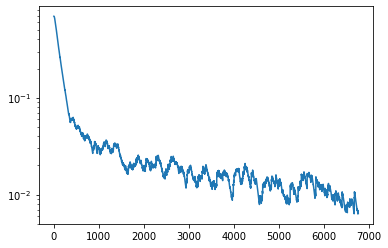

100%|██████████████████████████████████████████████████████████████████████████████| 3434/3434 [01:04<00:00, 53.26it/s]


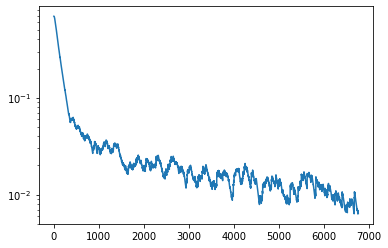

In [6]:
### 开始训练 ###

# 超参数设置

batch_size = 32
num_epochs = 2
learning_rate = 5e-4

optimizer = keras.optimizers.Adam(learning_rate)
loss_history = mdl.util.LossHistory(smoothing_factor=0.99)  # 记录loss值
plotter = mdl.util.PeriodicPlotter(sec=2, scale='semilogy')
if hasattr(tqdm, '_instances'): tqdm._instances.clear()  # 如果当前进度条有重复，则删去
    
def cnn_train_step(x, y):
    with tf.GradientTape() as tape:
        logists = cnn(x)
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logists)
    grads = tape.gradient(loss, cnn.trainable_variables)
    optimizer.apply_gradients(zip(grads, cnn.trainable_variables))
    return loss

# 开始训练
for epoch in range(num_epochs):
    for idx in tqdm(range(loader.get_train_size()//batch_size)):
        x, y = loader.get_batch(batch_size)
        loss = cnn_train_step(x, y)
        loss_history.append(loss.numpy().mean())
        plotter.plot(loss_history.get())

### Evaluate performance of the standard CNN

下一步评估CNN模型在训练集上分类的准确率.

In [7]:
batch_x, batch_y = loader.get_batch(5000)
pred_cnn = tf.round(tf.nn.sigmoid(cnn.predict(batch_x)))
acc_cnn = tf.reduce_mean(tf.cast(tf.equal(batch_y, pred_cnn), tf.float32))  # 先计算与真实值相等的个数，然后取平均即为准确率
print(f'CNN模型在训练集中的准确率：{acc_cnn.numpy():.2%}')

CNN模型在训练集中的准确率：99.68%


我们还将通过验证集中的独立数据进行评估CNN模型，对于测试数据，我们将根据Fitzpatrick标准对人脸进行分类：男性深色、浅色皮肤，女性深色、浅色皮肤.

先看一下验证集中的一些样本：

np.array(eval_faces).shape=(4, 5, 64, 64, 3)


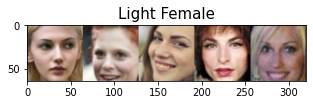

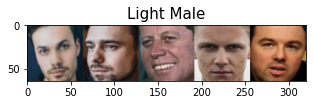

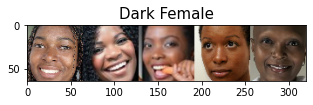

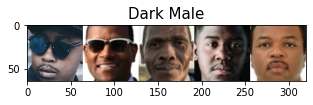

In [8]:
eval_faces = mdl.lab2.get_test_faces()
print(f'{np.array(eval_faces).shape=}')
keys = ["Light Female", "Light Male", "Dark Female", "Dark Male"]
for group, key in zip(eval_faces, keys):
    plt.figure(figsize=(5, 5))
    plt.imshow(np.hstack(group))
    plt.title(key, fontsize=15)

下面让我们对每一种人脸使用CNN模型进行分类.

在调整纵坐标范围时用到了以下函数：

`numpy.ptp(axis=None)`：返回在`axis`轴上的最大值-最小值，默认`axis=None`则返回全部元素中的最大值-最小值.

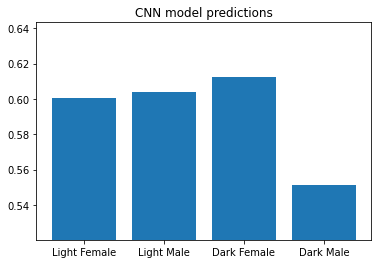

In [9]:
cnn_logists = [cnn(np.array(x, np.float32)) for x in eval_faces]
cnn_prob = tf.squeeze(tf.sigmoid(cnn_logists))

xx = range(len(keys))
yy = cnn_prob.numpy().mean(1)
plt.bar(xx, yy)
plt.xticks(xx, keys)
plt.ylim(max(0, yy.min()-yy.ptp()/2), yy.max()+yy.ptp()/2)
plt.title('CNN model predictions')
plt.show()

从上图可以看出，CNN模型对于深色男性的识别率相比其他三种人脸偏低. 因此该模型具有偏差(biased)，有可能是由训练数据集所导致的.

## 2.3 Mitigating algorithmic bias（减轻算法偏差）

由于训练数据集中人脸类别的不平衡可能会导致算法偏差. 例如，我们使用的CelebA训练集中，大多数人脸均为浅色女性. 因此该分类器更能识别该类别的人脸，而深色男性的识别率就比较低，这就是算法偏差.

解决方法：一种比较直接的解决方法（大多公司，组织所采用的）就是在训练集中注释（annotation）不同的子类（例如：浅色女性，戴帽子的男性等），最后再手动平衡这些数据.

但是该方法有两个缺点：1. 它需要大量的注释大量的数据，而且只能手工完成. 2. 它需要知道我们的模型有哪些隐偏差（例如：上述的肤色，还有种族、性别、姿势、遮挡、帽子、眼睛等），因此，手动注释可能无法捕获到全部的不平衡特征.

反之，让我们通过一种无监督（unsupervised）无偏的方法学习这些特征，无需手工注释，然后均匀地使用这些特征训练我们的分类器. 

下面让我们开始这个方法.

## 2.4 Variational autoencoder (VAE) for learning latent structure

从上面的结果可以看出，我们的CNN模型对于不同人脸的分类效果并不相同，说明我们的训练数据集中的肤色分布是存在偏差的，下面我们期望使用VAE模型去获得一个无偏的数据集，用于训练我们的模型.

变分自动编码器（Variational autoencoder, VAE）可以通过完全无监督的方式学习人脸数据中的潜在特征的编码.

![The concept of a VAE](https://s2.loli.net/2022/08/12/4pWXuJYfBLmivoq.jpg)

![VAE.png](https://s2.loli.net/2022/08/12/Js6cjeKZG52IDqM.png)

如上图和第四讲可知，VAE通过编码-解码（encoder-decoder）结构来学习输入数据的潜在表示. 在计算机视觉的文章中，编码网络（encoder network）用于接受输入图像，将它们编码为一系列由均值（mean）和标准差（standard deviation），然后从这些参数所定义Gauss分布中抽样（sample），得到一组隐变量. 然后通过解码网络（decoder network）对这些隐变量进行解码，以对原式图像进行重建.

在训练模型的过程中，可以通过VAE帮助识别那些隐变量对模型训练更加重要.

下面让我们具象化VAE的两个关键部分，并进行相关函数的定义.

### Understanding VAE: loss function

在实践中，我们如何训练一个VAE模型？在隐空间（latent space）的学习中，我们将均值和标准差向一个标准Gauss分布近似，这里需要对可学习参数进行更新，所以我们需要定义第一个损失函数（loss functino）. 并且VAE用这些参数进行图像重建后，还需考虑和输入图像的匹配程度，这里需要第二个损失函数. 因此我们VAE的损失函数具有两项：

1. **潜损失 Latent loss $L_{KL}$**：用于衡量隐变量和标准Gauss分布的匹配程度，这里由 Kullback-Leibler (KL) 散度所定义.

2. **重建损失 Reconstruction loss $L_{x}(x, \hat{x})$**：用于衡量重建所得到的图片与输入图片的匹配程度，由 $L^1$ 范数（或 $L^2$ 范数）所定义.

潜损失的表达式（KL散度，$\mu, \sigma$ 分别为编码的均值和标准差）：

$$
L_{KL}(\mu, \sigma) = \frac{1}{2}\sum_{j=0}^{k-1}(\sigma_j + \mu_j^2-1-\log\sigma_j)
$$

重建损失的表达式（$L^1$ 范数，其中 $x$ 为输入特征，$\hat{x}$ 为重建输出）：

$$
L_x(x,\hat{x}) = ||x-\hat{x}||_1
$$

综上，VAE损失为：

$$
L_{VAE} = c\cdot L_{KL} + L_x(x, \hat{x})
$$

其中 $c$ 为潜损失的权系数，即用于正则化的加权系数. 下面让我们开始定义VAE的损失函数：

使用 [`tf.reduce_sum(tensor, axis=None)`](https://tensorflow.google.cn/api_docs/python/tf/math/reduce_sum) 对向量`tensor`的`axis`这些维度进行求和，默认对全部元素进行求和.

类似地有 [`tf.reduce_mean(tensorf, axis=None`](https://tensorflow.google.cn/api_docs/python/tf/math/reduce_mean) 对向量`tensor`的`axis`这些维度求均值，默认对全部元素进行求均值.

In [10]:
### Defining the VAE loss function ###

def vae_loss_func(x, x_recon, mu, logsigma, kl_weight=0.0005):
    """
        x: 输入特征，
        x_recon: 重建输出，
        mu: 编码均值，
        logsigma: 标准差取log的结果，
        kl_weight: 潜损失的权系数
    """
    latent_loss = 0.5 * tf.reduce_sum(tf.exp(logsigma) + tf.square(mu) - 1.0 - logsigma, axis=1)
    reconstruction_loss = tf.reduce_mean(tf.abs(x - x_recon), axis=(1,2,3))
    vae_loss = kl_weight * latent_loss + reconstruction_loss
    return vae_loss

### Understanding VAE: reparameterization

VAE需要使用“重新参数化技巧”（reparameterization trick）对隐变量取样，由于隐变量 $z\sim Q(z|X)$ 而 $Q(z|X)$ 可由Gauss分布近似，则可以对 $z$ 按照特定均值和方差的Gauss分布进行取样，从而可以进行梯度下降法对参数进行学习. 假设VAE编码中生成的均值和方差分别为 $\mu, \sigma$，则隐变量（随机变量） $z\sim \mathcal{N}(\mu, \sigma^2I)$，可以通过多维标准正态分布平移和等比放缩得到：

设多维标准正态分布 $\varepsilon\sim \mathcal{N}(0, I)$，则

$$
z = \mu + \text{e}^{\frac{1}{2}\log\sum}\circ \varepsilon
$$

其中 $\sum = \sigma^2 I$ 为随机变量 $z$ 的协方差矩阵.

In [11]:
### VAE Reparameterization ###

def sampling(z_mean, z_logsigma):
    batch, latent_dim = z_mean.shape
    epsilon = tf.random.normal(shape=(batch, latent_dim))
    z = z_mean + tf.math.exp(0.5 * z_logsigma) * epsilon
    return z

## 2.5 Debaising variational autoencoder (DB-VAE)

下面我们使用VAE架构的一个核心理念来构造该模型，该理念称为去偏变分自动编码器(Debaising variational autoencoder, DB-VAE)，以减轻潜在训练集中的未知偏差. 我们将在面部识别任务上训练DB-VAE模型，在训练期间进行去偏操作，在PPB数据集上进行评估，并将其准确性与原始的有偏CNN模型进行比较.

### The DB-VAE model

这种去偏方法的核心思想是通过VAE学习的隐变量在训练期间自适应地重新从CelebA数据集中进行采样. 具体地说，我们将根据其潜在特征在数据集中出现的频率来改变训练中使用给定图像的概率. 因此出现频率低的特征（如：深色皮肤、太阳镜、帽子等）的面部图像更有可能在训练中被使用多次，而在训练集中出现次数过多的面部图像的使用概率应该降低（相对于均匀随机地对数据进行抽样训练）.

DB-VAE方法的示意图如下：

![DB-VAE.png](https://s2.loli.net/2022/08/15/dh2DaezCqGEwlWM.png)

回忆起我们期望使用DB-VAE继续拧有监督分类问题——人脸识别问题，即判断一张图片是否是人脸. 注意到，DB-VAE编码部分有一个单独输出的有监督变量 $z_0$，就和分类问题相关——是人脸或不是人脸. 而一般的VAE并不具有有监督变量输出的功能，这也是DB-VAE与传统VAE不同之处.

注意到我们的模型仅想学习人脸相关的潜在表示，因为这才能完成对数据集去偏操作，与此同时我们还在做一个二分类问题. 所以我们要确保模型**仅对人脸图片**从分布 $q_{\phi}(z|x)$ 中获取无监督隐变量的表示，并且输出一个有监督的分类预测 $z_0$，而对于非人脸图片，我们只需要输出一个预测 $z_0$ 即可.

### Defining the DB-VAE loss function

这意味着我们需要对DB-VAE的损失函数进行一些改进，损失函数要与是否是人脸图片相关.


对于人脸图片，我们的损失函数将包含两项：

1. VAE损失函数 $L_{VAE}$：包含潜损失和重建损失.

2. 分类损失 $L_y(y, \hat{y})$：二分类问题的标准交叉熵损失函数.

相反地，对于非人脸图片，我们的损失函数仅有分类损失这一项. 则DB-VAE损失函数为：

$$
L_{total}=  L_y(y, \hat{y}) + \chi_{image}(y)\cdot L_{VAE}
$$

其中 $\chi_{image}(y) = \begin{cases}1, &\quad y=1,\text{训练样本为人脸图片},\\ 0, &\quad y=0,\text{训练样本为非人脸图片.}\end{cases}$

下面开始定义DB-VAE的损失函数：

In [12]:
### Loss functino for DB-VAE ###

def debiasing_loss_func(x, x_pred, y, y_logit, mu, logsigma):
    vae_loss = vae_loss_func(x, x_pred, mu, logsigma)
    classification_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_logit)
    face_indicator = tf.cast(tf.equal(y, 1), tf.float32)
    total_loss = tf.reduce_mean(
        classification_loss + 
        face_indicator * vae_loss
    )
    return total_loss, classification_loss

### DB-VAE architecture

现在我们开始准备定义DB-VAE架构. 为了建立DB-VAE，我们将使用上文中使用的标准CNN分类器用于我们编码过程，然后定义解码神经网络. 我们先将初始化两个模型，然后构建一个端到端的VAE. 我们将使用一个包含100个隐变量的隐空间.

解码神经网络将从正态分布中抽样获取的隐变量作为输入，通过一系列的反卷积层，从而输出原始输入图片的重建结果.

In [13]:
### Define the decoder portion of the DB-VAE ###

n_filters = 12  # 卷积核个数，和标准CNN相同
latent_dim = 100  # 隐变量个数，隐空间维度

def make_face_decoder_network():
    Conv2DTranspose = functools.partial(layers.Conv2DTranspose, padding='same', activation='relu')
    return keras.Sequential([
        # 和上文中的CNN建图过程部分正好相反
        layers.Dense(units=4*4*6*n_filters),  # 特征映射大小为4*4（出现6N次）
        layers.Reshape(target_shape=(4, 4, 6*n_filters)),
        Conv2DTranspose(filters=4*n_filters, kernel_size=3, strides=2),
        Conv2DTranspose(filters=2*n_filters, kernel_size=3, strides=2),
        Conv2DTranspose(filters=1*n_filters, kernel_size=5, strides=2),
        Conv2DTranspose(filters=3, kernel_size=5, strides=2)
    ])

# make_face_decoder_network().summary()

接下来将解码器和编码器（标准CNN分类器）组合在一起构成DB-VAE网络. 到目前为止我们都还没有使用与“去偏”相关的操作，这需要在训练过程中进行定义. 这里我们通过继承 `Model` 类来定义VAE模型，包括：编码器，重新参数化，解码器，最后通过端到端的方法调用该网络.

In [14]:
### Defining and creating the DB-VAE ###

class DB_VAE(keras.Model):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        # 编码器输出大小，包含隐空间的估计和一个分类结果
        num_encoder_dims = 2*self.latent_dim + 1
        self.encoder = make_CNN_classifier(num_encoder_dims)
        self.decoder = make_face_decoder_network()
        
    def encode(self, x):  # 输入图像到编码器中，返回隐空间的参数和二分类的概率
        encoder_ouput = self.encoder(x)
        y_logit = tf.expand_dims(encoder_ouput[:, 0], -1)  # 取输出向量中第0维作为分类概率
        # 隐变量的均值和方差
        z_mean = encoder_ouput[:, 1:self.latent_dim+1]
        z_logsigma =  encoder_ouput[:, self.latent_dim+1:]
        return y_logit, z_mean, z_logsigma
    
    def reparameterize(self, z_mean, z_logsigma):  # VAE重新参数化，从正态分布中取样
        return sampling(z_mean, z_logsigma)
    
    def decode(self, z):
        return self.decoder(z)
    
    def call(self, x):  # 定义该模型的计算过程
        y_logit, z_mean, z_logsigma = self.encode(x)
        z = self.reparameterize(z_mean, z_logsigma)
        recon = self.decode(z)
        return y_logit, z_mean, z_logsigma, recon
    
    def predict(self, x):  # 预测给定的输入x是否是人脸图片
        y_logit, z_mean, z_logsigma = self.encode(x)
        return y_logit
    
dbvae = DB_VAE(latent_dim)

### Adaptive resampling for automated debiasing with DB-VAE（使用DB-VAE进行自动去偏的自适应重采样）

那么，如何使用DB-VAE来训练去偏的人脸识别分类器呢？

回想DB-VAE的架构：当图像通过网络输入时，编码器会学习得到隐空间中 $Q(z|X)$ 的估计. 我们希望通过增加对隐空间中代表性不足区域的采样，从而增加稀有数据的相对频率. 我们可以通过每个学习到的隐变量的频率分布对 $Q(z|X)$ 进行近似，然后根据该近似结果定义对样本抽取的概率分布，这个概率分布将用于数据的重新采样.

下面的函数将用于采样概率的更新，然后在DB-VAE训练循环中调用此函数，以消除数据集的偏差.

首先，我们定义了一个简短的辅助函数 `get_latent_mu`，它用于返回一个batch中的图像经过编码器后，得到的隐变量的均值.

In [15]:
def get_latent_mu(images, dbvae, batch_size=1024):
    N = images.shape[0]
    mu = np.zeros((N, latent_dim))
    for start_idx in range(0, N, batch_size):
        end_idx = min(start_idx+batch_size, N+1)
        x = (images[start_idx:end_idx])/255
        _, z_mu, _ = dbvae.encode(x)
        mu[start_idx:end_idx] = z_mu
    return mu

下面我们开始定义重采样算法 `get_training_sample_probabilities`. 尤其注意其中的参数 `smoothing_fac`，该参数用于调整去偏的程度，
当 `smoothing_fac=0` 时，重采样数据将在隐空间中均匀分布，一种极端的去偏方法.

In [16]:
### Resampling algorithm for DB-VAE ###

'''该函数基于图像在训练数据中的分布结果，重新一个batch中每个图像进行采样的概率'''
def get_training_sample_probabilities(images, dbvae, bins=10, smoothing_fac=0.001):
    print("Recomputing the sampling probabilities")
    mu = get_latent_mu(images, dbvae)  # 获取每个batch对应隐变量的均值
    training_sample_p = np.zeros(mu.shape[0])  # 保存每个样本抽样概率分布
    for i in range(latent_dim):  # 考虑每一个隐变量分布
        latent_distribution = mu[:, i]
        
        # 生成一个隐变量分布的直方图
        hist_density, bin_edges = np.histogram(latent_distribution, density=True, bins=bins)
        
        # 获得每个隐变量分布的位置，np.digitize()可以返回每个变量对应的分布位置
        bin_edges[0] = -float('inf')
        bin_edges[-1] = float('inf')
        bin_idx = np.digitize(latent_distribution, bin_edges)
        
        # 平滑密度函数
        hist_smoothed_density = hist_density + smoothing_fac
        hist_smoothed_density /= np.sum(hist_smoothed_density)
        
        # 反转密度函数
        p = 1 / (hist_smoothed_density[bin_idx-1])
        p /= np.sum(p)
        training_sample_p = np.maximum(p, training_sample_p)
        
    # 最后进行一次归一化操作
    training_sample_p /= np.sum(training_sample_p)
    return training_sample_p

现在我们可以开始使用CelebA/ImageNet训练数据对DB-VAE模型进行训练了，并且使用上述操作对特定样本进行重采样. 再次注意，我们只需要对人脸图片相关特征进行去偏，而不用对非人脸图片进行操作.

Starting epoch 15/15
Recomputing the sampling probabilities


  0%|                                                                                         | 0/3434 [00:00<?, ?it/s]

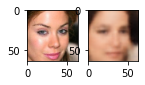

 14%|███████████▍                                                                   | 497/3434 [00:05<00:30, 97.68it/s]

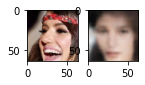

 29%|██████████████████████▍                                                      | 1000/3434 [00:10<00:23, 104.75it/s]

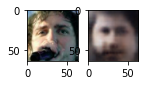

 43%|█████████████████████████████████▉                                            | 1493/3434 [00:15<00:20, 95.97it/s]

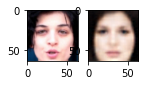

 58%|████████████████████████████████████████████▊                                | 1997/3434 [00:20<00:13, 105.47it/s]

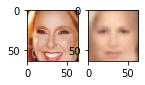

 73%|████████████████████████████████████████████████████████▌                     | 2490/3434 [00:25<00:09, 99.44it/s]

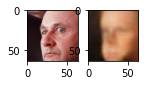

 87%|███████████████████████████████████████████████████████████████████▏         | 2996/3434 [00:29<00:04, 104.57it/s]

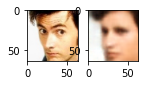

100%|█████████████████████████████████████████████████████████████████████████████| 3434/3434 [00:34<00:00, 100.25it/s]


In [17]:
### Training the DB-VAE ###

# 超参数配置
batch_size = 32
learning_rate = 5e-4
latent_dim = 100
num_epochs = 15  # 由于DB-VAE更加复杂，所以需要训练该模型更多次

dbvae = DB_VAE(latent_dim)
optimizer = keras.optimizers.Adam(learning_rate)

# 使用 @tf.function 可以将Python中的函数，转化为TensorFlow中的计算图，用于计算偏导数. 但在高版本中可以略去.
@tf.function
def debiasing_train_step(x, y):
    with tf.GradientTape() as tape:
        y_logit, z_mean, z_logsigma, x_recon = dbvae(x)
        loss, class_loss = debiasing_loss_func(x, x_recon, y, y_logit, z_mean, z_logsigma)
    grads = tape.gradient(loss, dbvae.trainable_variables)
    optimizer.apply_gradients(zip(grads, dbvae.trainable_variables))
    return loss

all_faces = loader.get_all_train_faces()
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # 如果进度条存在，则将其删除.

for i in range(num_epochs):
    IPython.display.clear_output(wait=True)
    print(f"Starting epoch {i+1}/{num_epochs}")
    
    # 重新计算重采样的概率
    p_faces = get_training_sample_probabilities(all_faces, dbvae)
    
    # 获取训练数据集，开始训练
    for j in tqdm(range(loader.get_train_size() // batch_size)):
        (x, y) = loader.get_batch(batch_size, p_pos=p_faces)
        loss = debiasing_train_step(x, y)
        if j % 500 == 0:
            mdl.util.plot_sample(x, y, dbvae)

In [21]:
plt.rcParams['axes.linewidth'] = 1  # 图框宽度
plt.rcParams['figure.dpi'] = 300  # plt.show显示分辨率
font = {'family': 'serif',
        'serif': 'Times New Roman',
        'weight': 'normal',
        'size': 16}
plt.rc('font', **font)

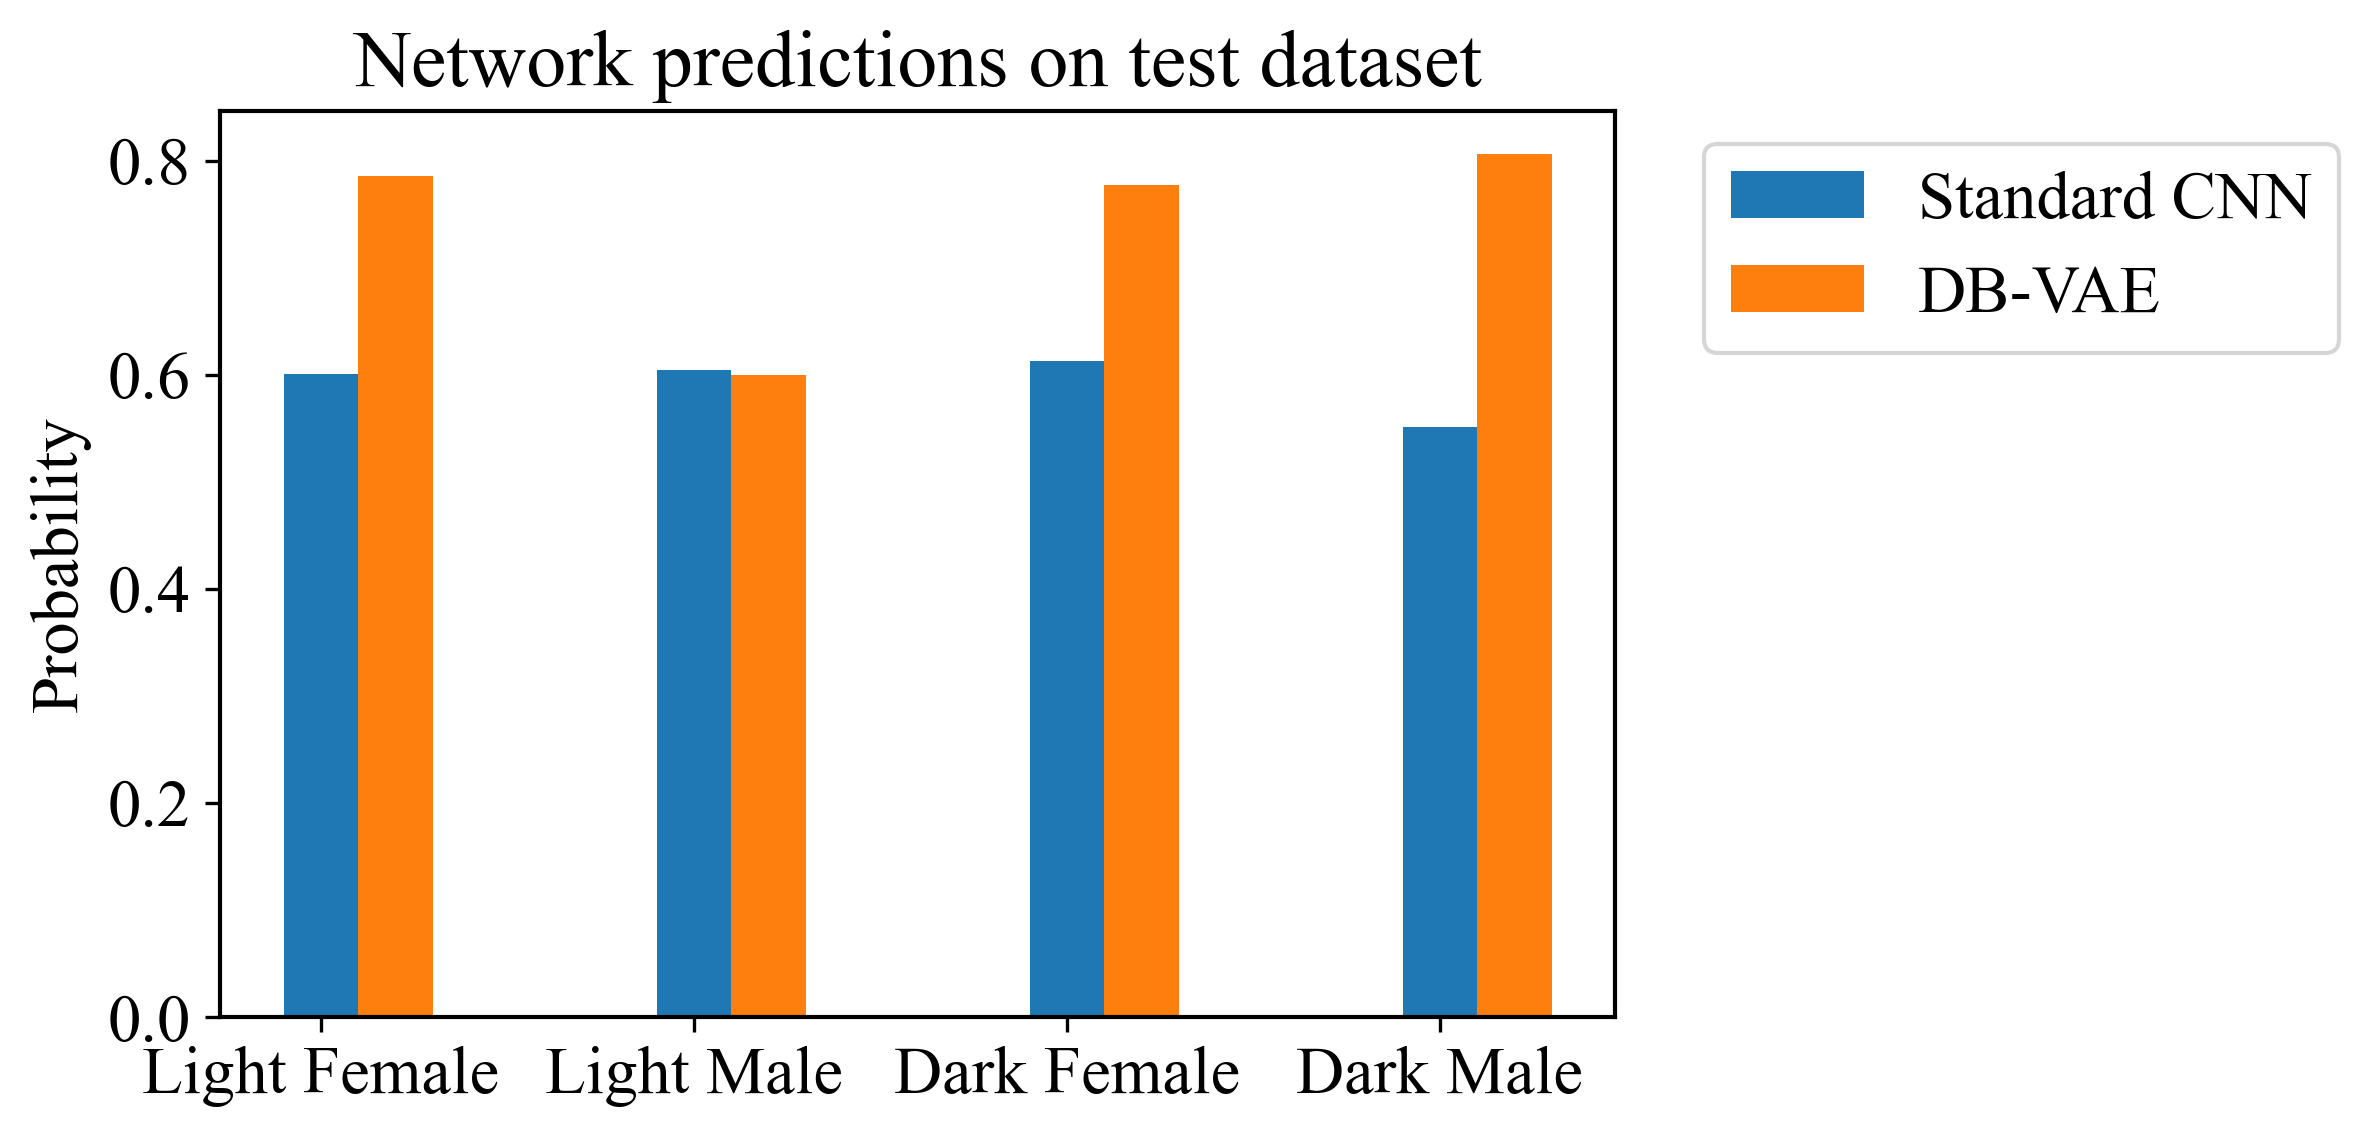

In [28]:
dbvae_logits = [dbvae.predict(np.array(x, dtype=np.float32)) for x in eval_faces]
dbvae_probs = tf.squeeze(tf.sigmoid(dbvae_logits))

xx = np.arange(len(keys))
plt.bar(xx, cnn_prob.numpy().mean(1), width=0.2, label="Standard CNN")
plt.bar(xx+0.2, dbvae_probs.numpy().mean(1), width=0.2, label="DB-VAE")
plt.xticks(xx, keys); 
plt.title("Network predictions on test dataset")
plt.ylabel("Probability"); plt.legend(bbox_to_anchor=(1.04,1), loc="upper left");
plt.savefig('compare_cnn_vae.pdf', bbox_inches = 'tight')

In [37]:
def show_origin_recon(idx):
    images = x[np.where(y==1)[0]]
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(images[idx])

    pred = dbvae(x)
    pred_img = pred[3].numpy()
    pred_img = pred_img[np.where(y==1)[0]]
    plt.subplot(1, 2, 2)
    plt.imshow(pred_img[idx])
    plt.show()
    
    pred_mu = pred[1].numpy()
    pred_logsigma = pred[2].numpy()
    return pred_mu[np.where(y==1)[0]][idx], pred_logsigma[np.where(y==1)[0]][idx]

def decode(mu, logsigma):
    mu = np.expand_dims(mu, axis=0)
    logsigma = np.expand_dims(logsigma, axis=0)
    z = sampling(mu, logsigma)
    recon = dbvae.decode(np.expand_dims(z, axis=0))
    plt.imshow(recon[0])

def show_gradiently(img1, img2, fig_name):
    mu1, logsigma1 = dbvae(np.expand_dims(img1, axis=0))[1:3]
    mu2, logsigma2 = dbvae(np.expand_dims(img2, axis=0))[1:3]

    N = 10
    d_mu = (mu2 - mu1) / N
    d_logsigma = (logsigma2 - logsigma1) / N
    plt.figure(figsize=(20, 20))
    plt.subplot(1, N+2, 1)
    plt.imshow(img1)
    plt.axis('off')
    for i in range(N+1):
        plt.subplot(1, N+2, i+2)
        #decode(mu1, logsigma1)
        recon = dbvae.decode(mu1)[0]
        plt.imshow(recon)
        plt.axis('off')
        mu1 += d_mu
        logsigma1 += d_logsigma
    plt.subplot(1, N+2, N+2)
    plt.imshow(img2)
    plt.axis('off')
    plt.savefig(fig_name + '.png', bbox_inches = 'tight')
    plt.savefig(fig_name + '.pdf', bbox_inches = 'tight')
    plt.show()
        
def show_pred_mid(img):
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    input_x = np.expand_dims(img, axis=0)
    mu = np.expand_dims(dbvae(input_x)[1][0].numpy(), axis=0)
    recon = dbvae.decode(mu)[0]
    plt.subplot(1, 2, 2)
    plt.imshow(recon)
    plt.show()
    

In [104]:
idx1, idx2 = 10, 20
x, y = loader.get_batch(100)
images = x[np.where(y==1)[0]]

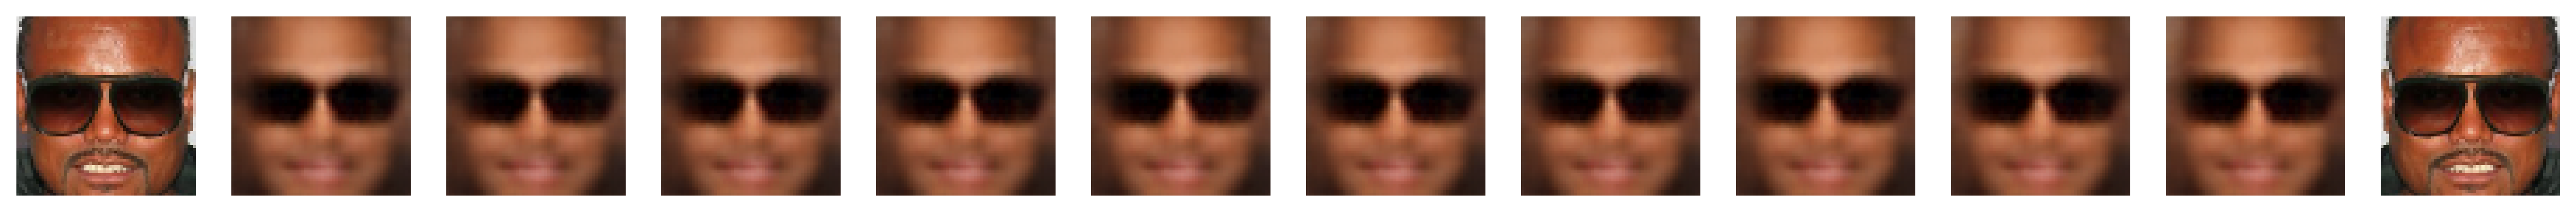

In [105]:
img = images[idx1]
# plt.subplot(1, 2, 1)
# plt.imshow(img)
img_flip = tf.image.flip_left_right(img)
# plt.subplot(1, 2, 2)
# plt.imshow(img_flip)
# plt.show()
show_gradiently(img, img_flip, 'gradient1')

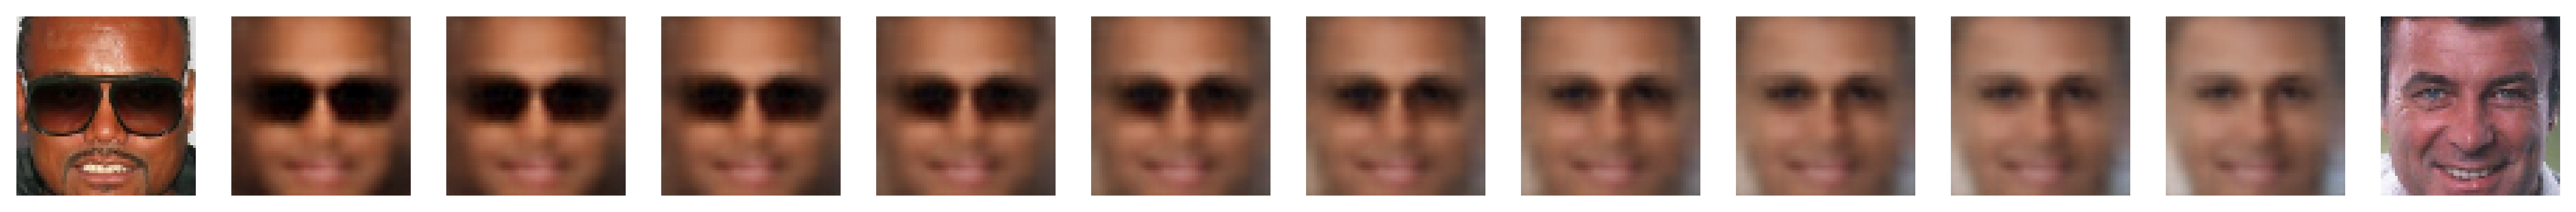

In [106]:
show_gradiently(images[idx1], images[idx2], 'gradient11')